In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon

import yolo3_one_file_to_detect_them_all as yolo3
from keras.models import load_model

from datetime import datetime

%matplotlib inline

# Player Tracking

In [2]:
model = yolo3.make_yolov3_model()
weight_reader = yolo3.WeightReader('./data/weights/yolov3.weights')
weight_reader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [3]:
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person"]

In [4]:
PATH = './data/downverse.com - Ma Long vs Fan Zhendong  Bank of Communications 2020 ITTF Finals (Final) trimmed.mp4'
scaling_factor = 0.5

cap = cv2.VideoCapture(PATH)
ret, img = cap.read()
new_h, new_w = int(img.shape[1]*scaling_factor), int(img.shape[0]*scaling_factor)
img = cv2.resize(img, (new_h, new_w), interpolation=cv2.INTER_AREA)
h, w, _ = img.shape

In [5]:
# vid_path = './data/downverse.com - Ma Long vs Fan Zhendong  Bank of Communications 2020 ITTF Finals (Final) trimmed.mp4'
# save_path = './data/yolo_video_test.mp4'

# cap = cv2.VideoCapture(vid_path)

# video_FourCC = int(cap.get(cv2.CAP_PROP_FOURCC))
# video_fps    = cap.get(cv2.CAP_PROP_FPS)
# video_size   = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
# writer = cv2.VideoWriter(save_path, video_FourCC, video_fps, video_size)

# q_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# deciles = [int(x) for x in np.linspace(0,1,11)*q_frames]
# frame_number = 0

# start_time = datetime.now()
# while True:
#     ret, frame = cap.read()
#     frame_number += 1
    
#     if ret == True:
#         h, w, _ = frame.shape
#         img = yolo3.preprocess_input(frame, net_h, net_w)
        
#         preds = model.predict(img)
#         bboxes = []
        
#         for i in range(len(preds)):
#             bboxes += yolo3.decode_netout(preds[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)
        
#         yolo3.correct_yolo_boxes(bboxes, h, w, net_h, net_w)
#         yolo3.do_nms(bboxes, nms_thresh)
#         yolo3.draw_boxes(frame, bboxes, labels, obj_thresh)
        
#         if frame_number in deciles:
#             print('Processed frames: {} out of {} ({}%)'.format(frame_number, q_frames, np.round(frame_number*100/q_frames, 0)))
# #         writer.write(frame)
        
#         cv2.imshow('YOLO with Video Prediction', frame)
        
#         if frame_number == q_frames:
#             break
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

# print("Finished")
# print("Elapsed time:", datetime.now() - start_time)
# writer.release()
# cap.release()
# cv2.destroyAllWindows()

In [26]:
src_pts = np.array([
    [1, 86], 
    [1, 326], 
    [413, 326], 
    [413, 86]
])

dst_pts = np.array([
      [1,  1],     
      [1,  413],    
      [415,  415],    
      [415,  1],  
    ])

In [27]:
im_poly = img_copy[0].copy()

# cv2.fillPoly(img_src, [src_pts], 255)
cv2.polylines(im_poly, [src_pts], isClosed=True, color=[0,255,255], thickness=2)
# plt.imshow(im_poly)
cv2.imshow('Court', im_poly)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [28]:
def drawPlayers(im, pred_boxes, pred_classes, showResult=False):
    
    color = [255, 0, 0]
    thickness = 3
    radius = 3

    i  = 0
    for box in pred_boxes:

        # Include only class Person
        ##if pred_classes[i] == 'Person':  

        x1 = int(box.xmin)
        y1 = int(box.ymin)
        x2 = int(box.xmax)
        y2 = int(box.ymax)

        xc = x1 + int((x2 - x1)/2)
        player_pos = (xc - 1, y2 - 25)

        court = Polygon(src_pts)

        # Draw only players that are within the court
        if (box.classes[0] > obj_thresh) & (Point(player_pos).within(court)):
            if showResult:
                print("[% 3d, % 3d]" %(xc, y2))

            cv2.circle(im, player_pos, radius, color, thickness)
            i = i + 1            

    if showResult:
        plt.imshow(im)
#         cv2.imshow('Court', im)
        
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()        

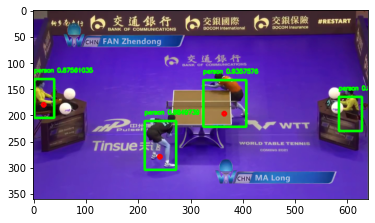

In [29]:
img_copy = yolo3.preprocess_input(img, net_h, net_w)
preds = model.predict(img_copy)
bboxes = []

for i in range(len(preds)):
    bboxes += yolo3.decode_netout(preds[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

yolo3.correct_yolo_boxes(bboxes, h, w, net_h, net_w)
yolo3.do_nms(bboxes, nms_thresh)
obj = yolo3.draw_boxes(img, bboxes, labels, obj_thresh)

plt.imshow(img)
# cv2.imshow('YOLO prediction', img)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

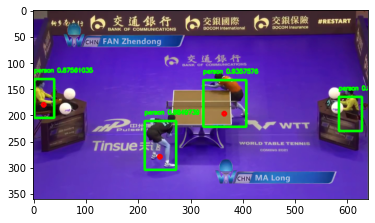

In [30]:
drawPlayers(obj, bboxes, labels, showResult=True)

In [31]:
def homographyTransform(img_src, img_dst, showResult=False):

    # Calculate Homography
    h, status = cv2.findHomography(src_pts, dst_pts)
    img_out = cv2.warpPerspective(img_src, h, (img_dst.shape[1], img_dst.shape[0]))
    
    if showResult:
        plt.imshow(img_out)
#         cv2.imshow('Court', img_out)
        
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

    return img_out

def getPlayersMask(im):
    lower_range = np.array([255,0,0])                         # Set the Lower range value of blue in BGR
    upper_range = np.array([255,155,155])                     # Set the Upper range value of blue in BGR
    mask = cv2.inRange(im, lower_range, upper_range)          # Create a mask with range
    result = cv2.bitwise_and(im, im, mask = mask)             # Performing bitwise and operation with mask in img variable
    # cv2_imshow(result)                              

    return cv2.inRange(result, lower_range, upper_range)  

(512, 768, 3)

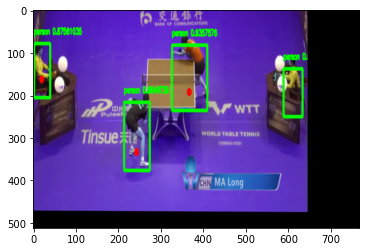

In [32]:
court = cv2.imread('./data/large_thumbnail.jpg')

img_homography = homographyTransform(img, court, showResult=True)
img_homography.shape

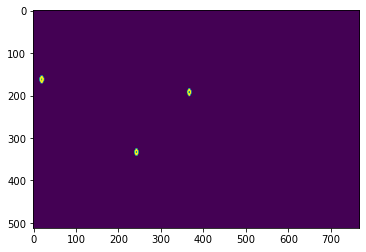

In [33]:
mask = getPlayersMask(img_homography)
plt.imshow(mask)